# PII Detection Benchmarking Analysis

## 1. Setup and Dependencies
Install and import the necessary Python libraries for data manipulation, metrics calculation, and visualization.

In [4]:
import pandas as pd
import json
import os
from fuzzywuzzy import fuzz
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Data Loading and Preprocessing
Load the ground truth and detected PII data from the specified directories. The code will:
1. Traverse the ground truth directory structure (`docsjson/<alias>/<language>/<split>`).
2. Match each ground truth file with its corresponding detected JSON file.
3. Use `utf-8` encoding to correctly handle special characters.
4. Parse the specific JSON structures for both ground truth and detected names.
5. Merge the data with the processing times CSV.

In [7]:
ground_truth_base_path = '/home/stark007/MayaDataPrivacy/TESTAPI/DatasetTransformation/output/docsjson'
detected_path = '/home/stark007/MayaDataPrivacy/ai-safe/benchmarking_uploads/Detected_values(dev_train)_docs'
processing_times_path = '/home/stark007/MayaDataPrivacy/ai-safe/benchmarking_uploads/processing_times.csv'

data = []
all_aliases = os.listdir(ground_truth_base_path)

print_counter = 0
for alias in all_aliases:
    alias_path = os.path.join(ground_truth_base_path, alias)
    if not os.path.isdir(alias_path): continue
    
    for lang in os.listdir(alias_path):
        lang_path = os.path.join(alias_path, lang)
        if not os.path.isdir(lang_path): continue
        
        for data_split in ['dev', 'train']:
            split_path = os.path.join(lang_path, data_split)
            if not os.path.isdir(split_path): continue
            
            for file_name in os.listdir(split_path):
                if file_name.endswith('.json'):
                    detected_file_path = os.path.join(detected_path, file_name)
                    
                    if os.path.exists(detected_file_path):
                        if print_counter < 10:
                            print(f"--- Comparison Pair {print_counter + 1} ---")
                            print(f"  Ground Truth File: {os.path.join(split_path, file_name)}")
                            print(f"  Detected File:     {detected_file_path}")

                        try:
                            with open(os.path.join(split_path, file_name), 'r', encoding='utf-8') as f:
                                ground_truth_data = json.load(f)
                            
                            with open(detected_file_path, 'r', encoding='utf-8') as f:
                                detected_data = json.load(f)
                                
                            ground_truth_names = []
                            for page, names in ground_truth_data.items():
                                if isinstance(names, dict):
                                    ground_truth_names.extend(names.values())
                            
                            detected_names = detected_data.get('Names', [])
                            
                            if print_counter < 100:
                                print(f"Ground Truth Names:{ground_truth_names}")
                                print(f"Detected Names:{detected_names}")
                                print_counter += 1

                            data.append({
                                'file_name': file_name,
                                'language': lang,
                                'doc_type': alias,
                                'ground_truth': ground_truth_names,
                                'detected': detected_names
                            })
                        except json.JSONDecodeError as e:
                            print(f"Skipping file {file_name} due to JSON error: {e}")
                        except Exception as e:
                            print(f"An error occurred with file {file_name}: {e}")

df = pd.DataFrame(data)

# Merge with processing times data
if os.path.exists(processing_times_path):
    processing_times_df = pd.read_csv(processing_times_path)
    # Ensure file names match for merging (e.g., .json vs .docx)
    processing_times_df['file_name_json'] = processing_times_df['File Name'].str.replace('.docx', '.json', regex=False)
    df = pd.merge(df, processing_times_df, left_on='file_name', right_on='file_name_json', how='left')
    df.drop(['File Name', 'file_name_json'], axis=1, inplace=True, errors='ignore')

print(f"Loaded {len(df)} matching files.")
df.head()

--- Comparison Pair 1 ---
  Ground Truth File: /home/stark007/MayaDataPrivacy/TESTAPI/DatasetTransformation/output/docsjson/hipe2020/fr/dev/hipe2020_fr_dev_chunk95.json
  Detected File:     /home/stark007/MayaDataPrivacy/ai-safe/benchmarking_uploads/Detected_values(dev_train)_docs/hipe2020_fr_dev_chunk95.json
Ground Truth Names:[]
Detected Names:['Atariase', 'Choi']
--- Comparison Pair 2 ---
  Ground Truth File: /home/stark007/MayaDataPrivacy/TESTAPI/DatasetTransformation/output/docsjson/hipe2020/fr/dev/hipe2020_fr_dev_chunk27.json
  Detected File:     /home/stark007/MayaDataPrivacy/ai-safe/benchmarking_uploads/Detected_values(dev_train)_docs/hipe2020_fr_dev_chunk27.json
Ground Truth Names:[]
Detected Names:[]
--- Comparison Pair 3 ---
  Ground Truth File: /home/stark007/MayaDataPrivacy/TESTAPI/DatasetTransformation/output/docsjson/hipe2020/fr/dev/hipe2020_fr_dev_chunk122.json
  Detected File:     /home/stark007/MayaDataPrivacy/ai-safe/benchmarking_uploads/Detected_values(dev_train)_do

,file_name,language,doc_type,ground_truth,detected,Request ID,Start Time,Processing Time (s),End Time,Total Detected Values
0,hipe2020_fr_dev_chunk95.json,fr,hipe2020,[],"[Atariase, Choi]",eca5e89f-c180-405b-aa4c-f7f35f661735,2025-07-04 16:14:43,2.688777,2025-07-04 16:14:46,2
1,hipe2020_fr_dev_chunk27.json,fr,hipe2020,[],[],cee7171f-d9f3-4820-af3a-e67f173577de,2025-07-04 16:14:19,3.020676,2025-07-04 16:14:22,0
2,hipe2020_fr_dev_chunk122.json,fr,hipe2020,[],"[Barbara, Gèiser-, Peyer, Pierre, Biner, Franc...",07509eba-8bbf-4220-90f3-4a42e2b328b9,2025-07-04 16:14:59,3.323578,2025-07-04 16:15:02,13
3,hipe2020_fr_dev_chunk46.json,fr,hipe2020,[],"[Pascal, Hofer, David, Wehren, Cindy, Santos]",14ec43d0-16ce-41a0-8ae1-e64803a95f37,2025-07-04 16:14:03,2.703664,2025-07-04 16:14:05,6
4,hipe2020_fr_dev_chunk10.json,fr,hipe2020,[],"[M., Calouder, M., Dind]",fe6d6f47-e929-48fb-b665-816efd5799a8,2025-07-04 16:14:27,2.923593,2025-07-04 16:14:30,4


## 3. Metrics Calculation
Define the functions to calculate performance metrics. The core function `calculate_metrics` computes True Positives (TP), False Positives (FP), and False Negatives (FN), which are then used to derive Accuracy, Precision, Recall, and F1-Score. This is done for both strict (exact match) and fuzzy (similarity-based) comparisons.

The `calculate_aggregate_metrics` function ensures that metrics are computed globally over the entire set of entities for a given group, which is the standard for academic benchmarking.

In [3]:
def calculate_metrics(ground_truth, detected, fuzzy=False, threshold=80):
    """Calculates TP, FP, FN and derived metrics for a given set of ground truth and detected lists."""
    gt_set = set(ground_truth)
    det_set = set(detected)
    
    if not fuzzy:
        true_positives = len(gt_set.intersection(det_set))
        false_positives = len(det_set.difference(gt_set))
        false_negatives = len(gt_set.difference(det_set))
    else:
        true_positives = 0
        matched_gt = set()
        matched_det = set()
        for det_item in detected:
            best_match_score = 0
            best_gt_item = None
            for gt_item in ground_truth:
                if gt_item in matched_gt: continue
                score = fuzz.ratio(det_item, gt_item)
                if score > best_match_score:
                    best_match_score = score
                    best_gt_item = gt_item
            
            if best_match_score >= threshold and best_gt_item:
                true_positives += 1
                matched_gt.add(best_gt_item)
                matched_det.add(det_item)
        
        false_positives = len(detected) - true_positives
        false_negatives = len(ground_truth) - true_positives
        
    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # Accuracy here is Jaccard Index, a common metric for set similarity.
    accuracy = true_positives / (true_positives + false_positives + false_negatives) if (true_positives + false_positives + false_negatives) > 0 else 0
    
    return accuracy, f1, precision, recall, false_positives, false_negatives

def get_aggregate_metrics(df_group):
    """Aggregates all entities in a dataframe group and calculates metrics on the entire set."""
    all_ground_truth = [name for sublist in df_group['ground_truth'] for name in sublist]
    all_detected = [name for sublist in df_group['detected'] for name in sublist]
    
    s_acc, s_f1, s_prec, s_rec, s_fp, s_fn = calculate_metrics(all_ground_truth, all_detected, fuzzy=False)
    f_acc, f_f1, f_prec, f_rec, f_fp, f_fn = calculate_metrics(all_ground_truth, all_detected, fuzzy=True)
    
    return pd.Series({
        'strict_accuracy': s_acc, 'strict_f1': s_f1, 'strict_precision': s_prec, 'strict_recall': s_rec, 'strict_fp': s_fp, 'strict_fn': s_fn,
        'fuzzy_accuracy': f_acc, 'fuzzy_f1': f_f1, 'fuzzy_precision': f_prec, 'fuzzy_recall': f_rec, 'fuzzy_fp': f_fp, 'fuzzy_fn': f_fn
    })

# --- Metric Calculation --- 
print('Calculating Overall Metrics...')
overall_metrics = get_aggregate_metrics(df).to_frame(name='Overall')
print(overall_metrics.transpose())

print('Calculating Language-wise Metrics...')
language_metrics = df.groupby('language').apply(get_aggregate_metrics)
print(language_metrics)

print('Calculating Document-type-wise Metrics...')
doc_type_metrics = df.groupby('doc_type').apply(get_aggregate_metrics)
print(doc_type_metrics)

Calculating Overall Metrics...
         strict_accuracy  strict_f1  strict_precision  strict_recall  \
Overall              0.0        0.0               0.0            0.0   

         strict_fp  strict_fn  fuzzy_accuracy  fuzzy_f1  fuzzy_precision  \
Overall    17370.0        0.0             0.0       0.0              0.0   

         fuzzy_recall  fuzzy_fp  fuzzy_fn  
Overall           0.0   47561.0       0.0  
Calculating Language-wise Metrics...
          strict_accuracy  strict_f1  strict_precision  strict_recall  \
language                                                                
de                    0.0        0.0               0.0            0.0   
en                    0.0        0.0               0.0            0.0   
fi                    0.0        0.0               0.0            0.0   
fr                    0.0        0.0               0.0            0.0   
sv                    0.0        0.0               0.0            0.0   

          strict_fp  strict_fn  fu

/tmp/ipykernel_8294/4180504196.py:60: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  language_metrics = df.groupby('language').apply(get_aggregate_metrics)
/tmp/ipykernel_8294/4180504196.py:64: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  doc_type_metrics = df.groupby('doc_type').apply(get_aggregate_metrics)


## 4. Visualization of Results
Plot the calculated metrics to visually compare performance. A dedicated plotting function is created to generate a comprehensive set of charts for each level of analysis (per-language and per-document-type).

--- Language-wise Metrics Visualization ---


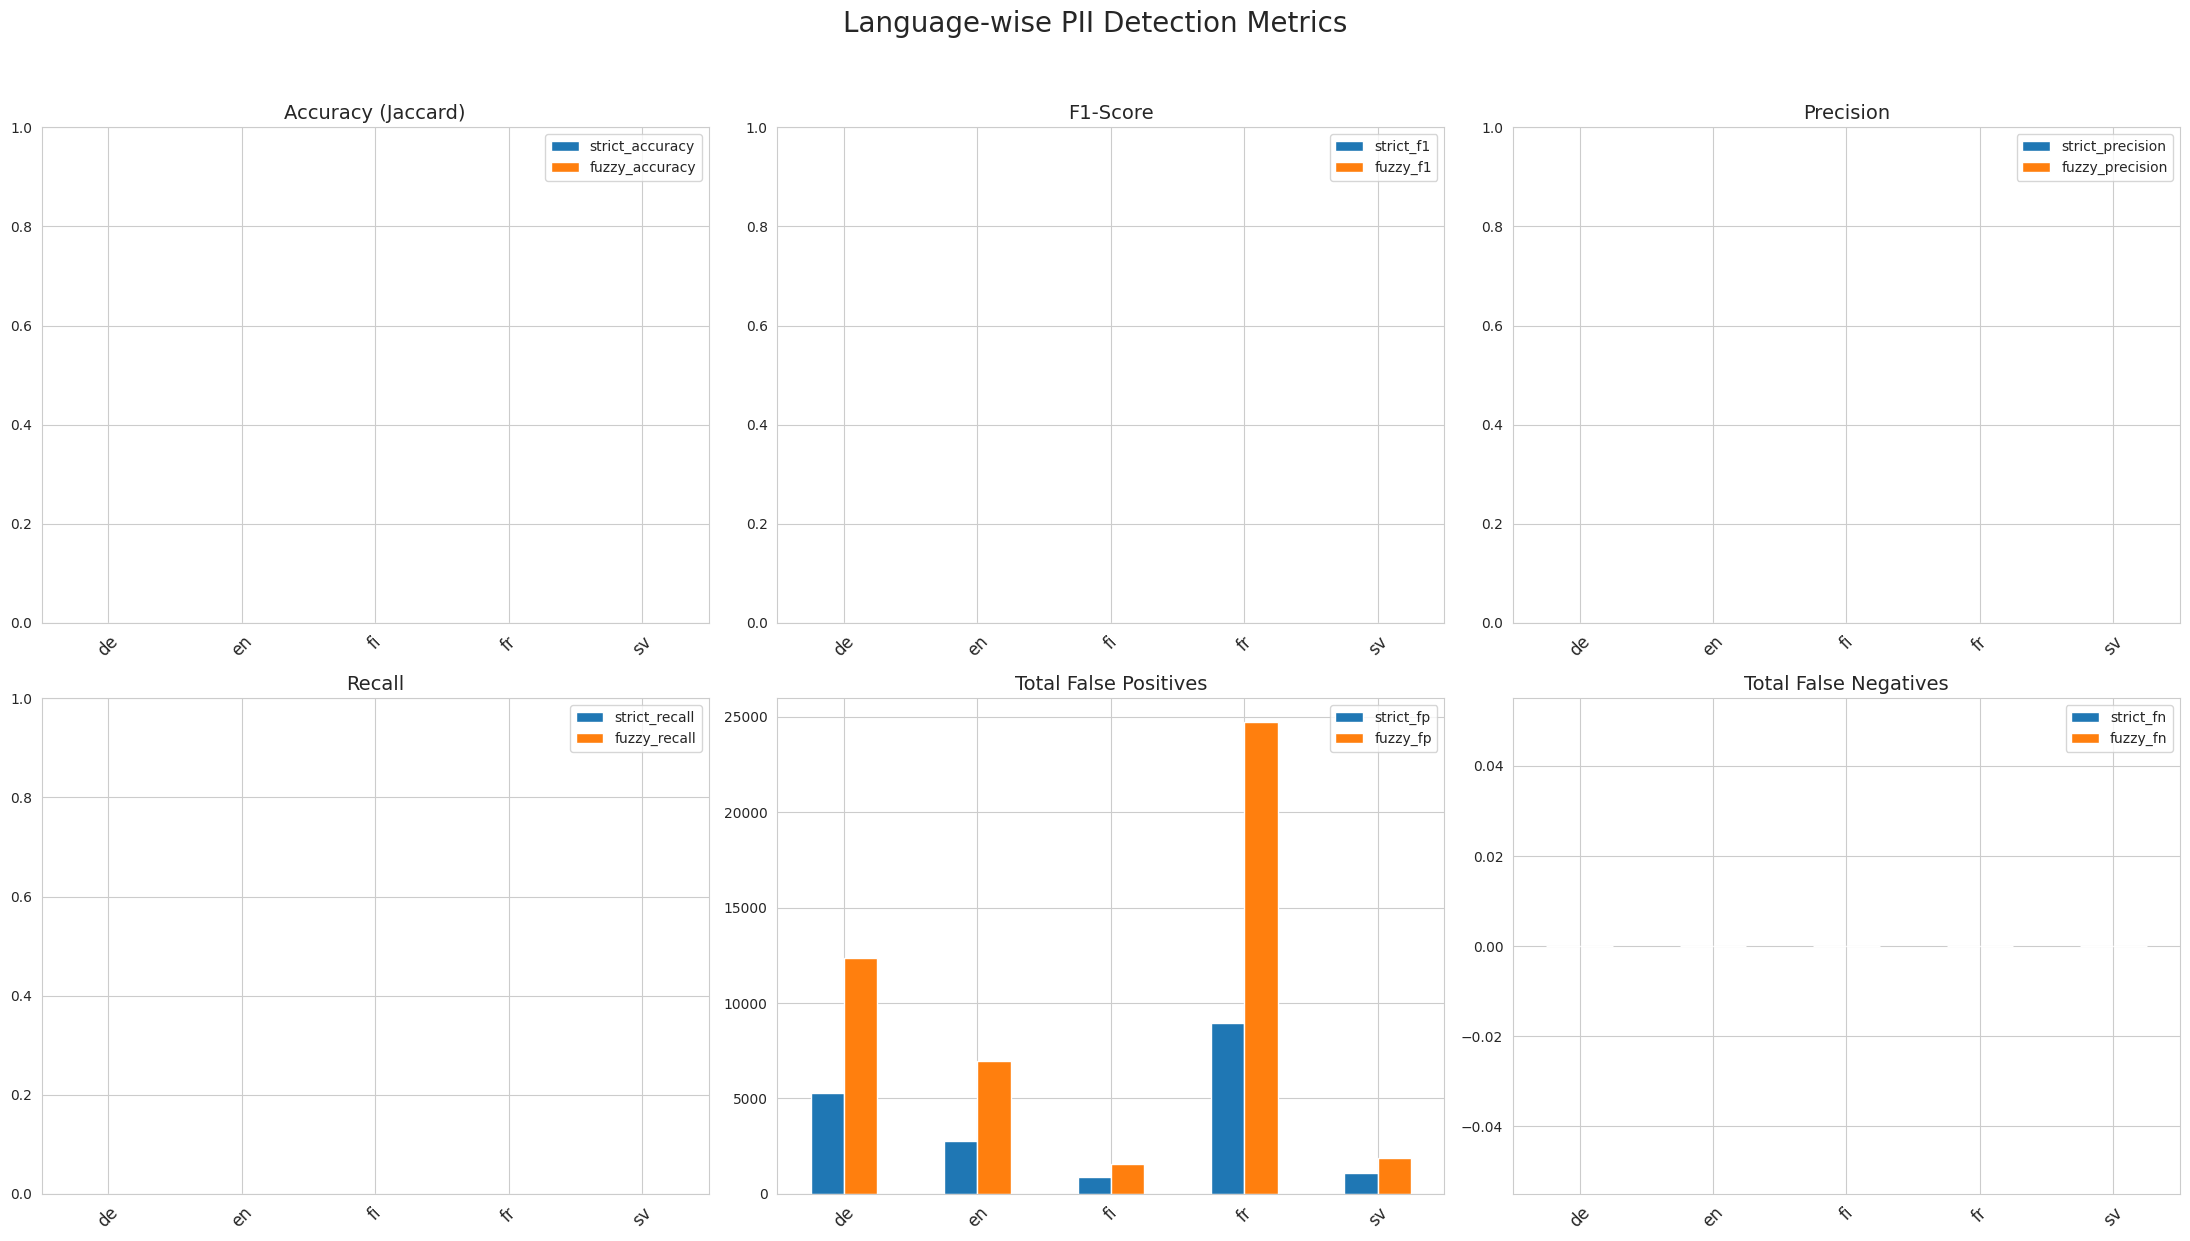

Document-type-wise Metrics Visualization ---


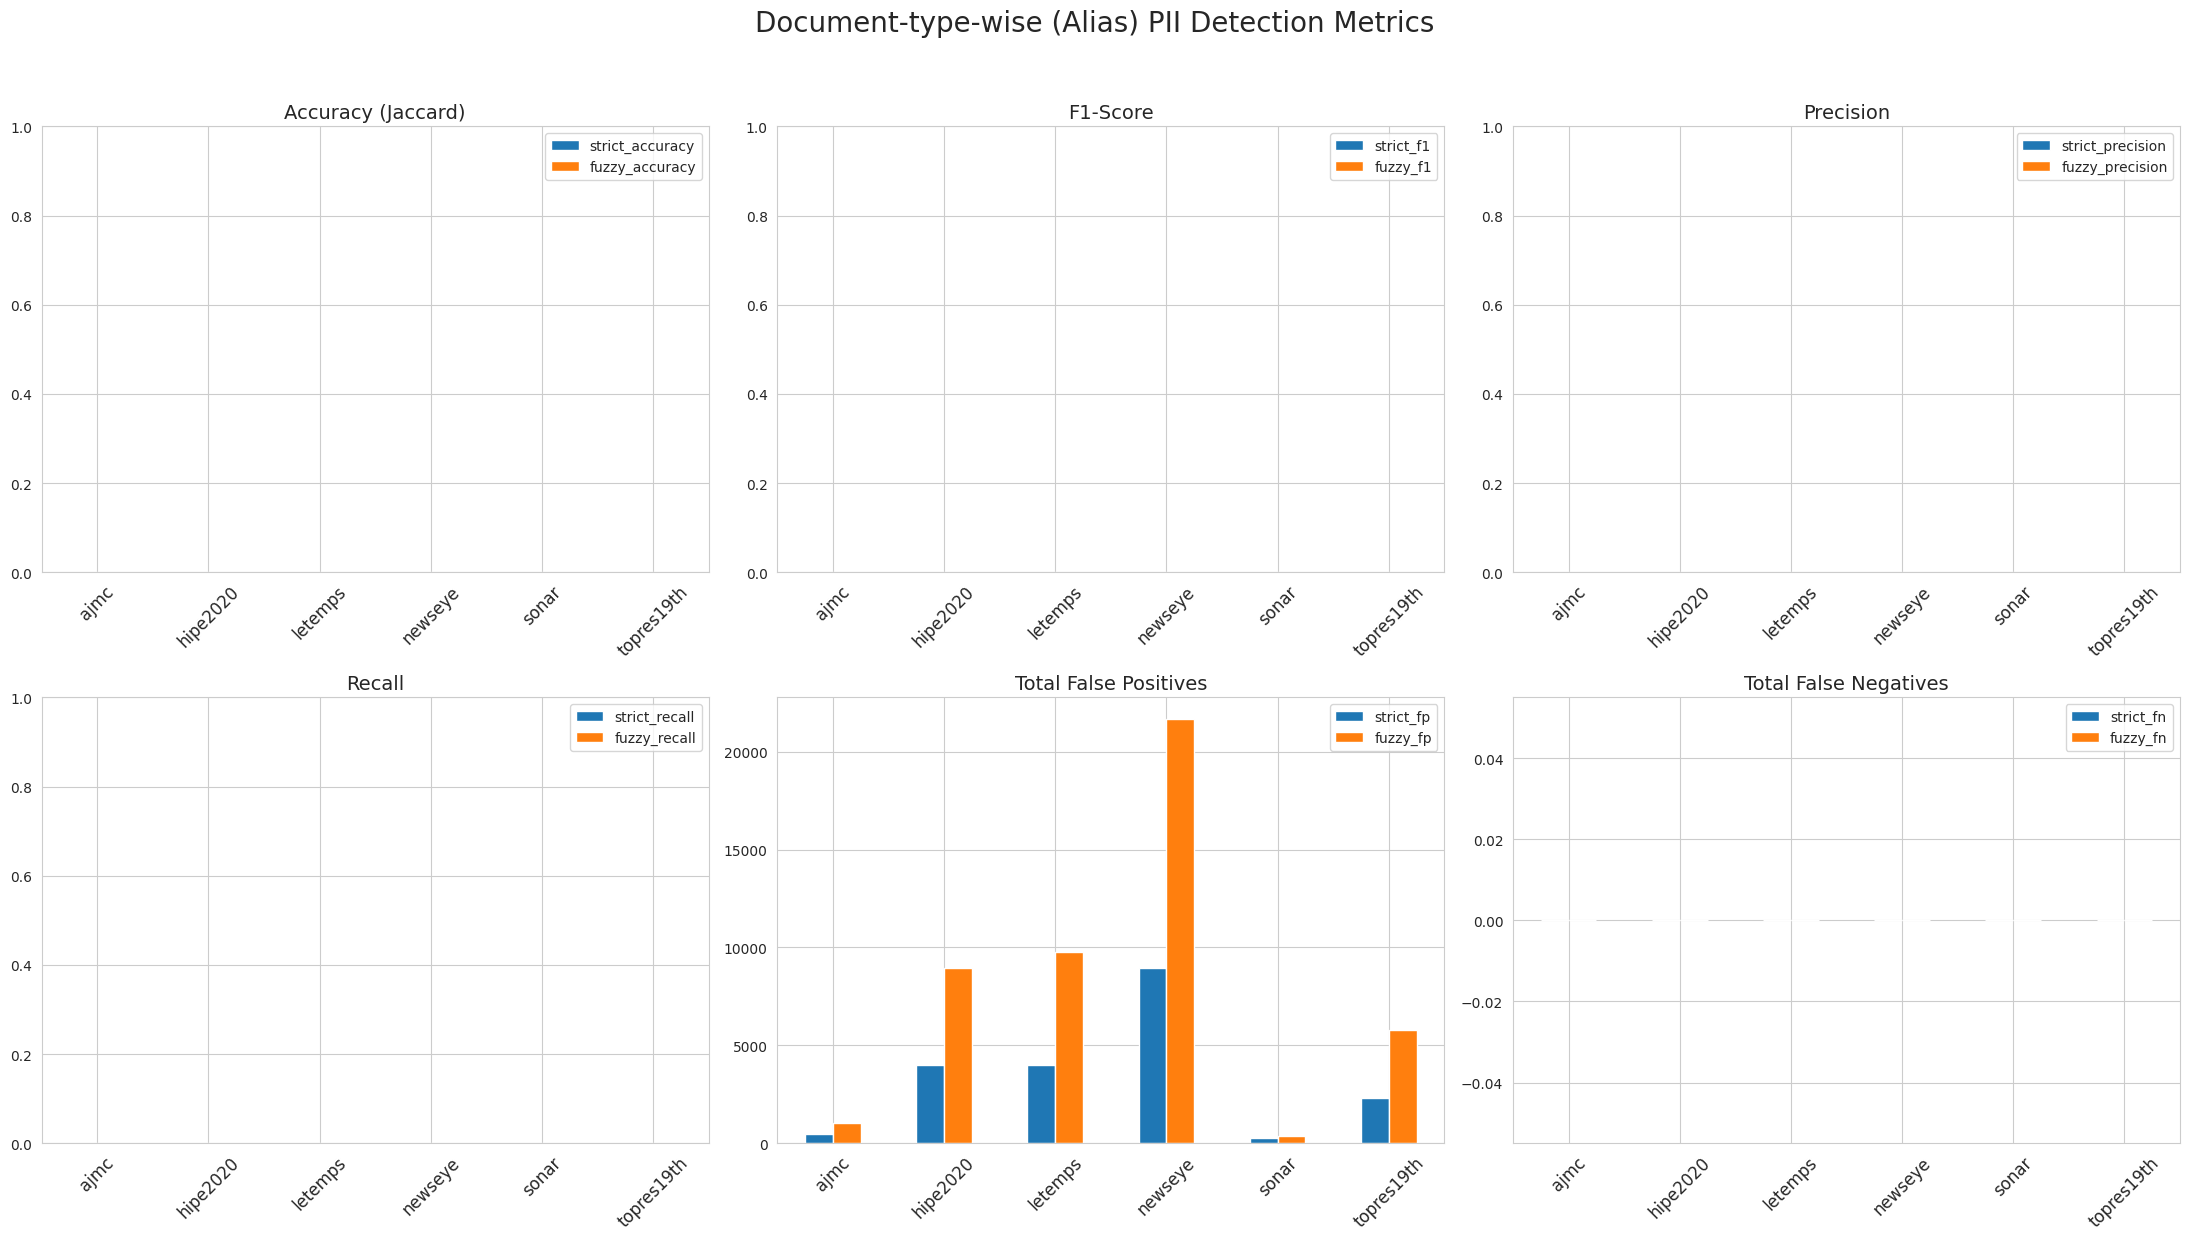

In [4]:
def plot_all_metrics(metrics_df, title_prefix):
    """Generates a 2x3 grid of bar charts for all key PII metrics."""
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))
    fig.suptitle(f'{title_prefix} PII Detection Metrics', fontsize=20, y=1.03)
    
    # Accuracy
    metrics_df[['strict_accuracy', 'fuzzy_accuracy']].plot(kind='bar', ax=axes[0, 0], legend=True)
    axes[0, 0].set_title('Accuracy (Jaccard)', fontsize=14)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].tick_params(axis='x', rotation=45, labelsize=12)
    axes[0, 0].set_xlabel('')
    
    # F1-Score
    metrics_df[['strict_f1', 'fuzzy_f1']].plot(kind='bar', ax=axes[0, 1], legend=True)
    axes[0, 1].set_title('F1-Score', fontsize=14)
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].tick_params(axis='x', rotation=45, labelsize=12)
    axes[0, 1].set_xlabel('')
    
    # Precision
    metrics_df[['strict_precision', 'fuzzy_precision']].plot(kind='bar', ax=axes[0, 2], legend=True)
    axes[0, 2].set_title('Precision', fontsize=14)
    axes[0, 2].set_ylim(0, 1)
    axes[0, 2].tick_params(axis='x', rotation=45, labelsize=12)
    axes[0, 2].set_xlabel('')
    
    # Recall
    metrics_df[['strict_recall', 'fuzzy_recall']].plot(kind='bar', ax=axes[1, 0], legend=True)
    axes[1, 0].set_title('Recall', fontsize=14)
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].tick_params(axis='x', rotation=45, labelsize=12)
    axes[1, 0].set_xlabel('')
    
    # False Positives
    metrics_df[['strict_fp', 'fuzzy_fp']].plot(kind='bar', ax=axes[1, 1], legend=True)
    axes[1, 1].set_title('Total False Positives', fontsize=14)
    axes[1, 1].tick_params(axis='x', rotation=45, labelsize=12)
    axes[1, 1].set_xlabel('')
    
    # False Negatives
    metrics_df[['strict_fn', 'fuzzy_fn']].plot(kind='bar', ax=axes[1, 2], legend=True)
    axes[1, 2].set_title('Total False Negatives', fontsize=14)
    axes[1, 2].tick_params(axis='x', rotation=45, labelsize=12)
    axes[1, 2].set_xlabel('')
    
    plt.tight_layout()
    plt.show()

print("--- Language-wise Metrics Visualization ---")
plot_all_metrics(language_metrics, 'Language-wise')

print("Document-type-wise Metrics Visualization ---")
plot_all_metrics(doc_type_metrics, 'Document-type-wise (Alias)')

## 5. Processing Time Analysis

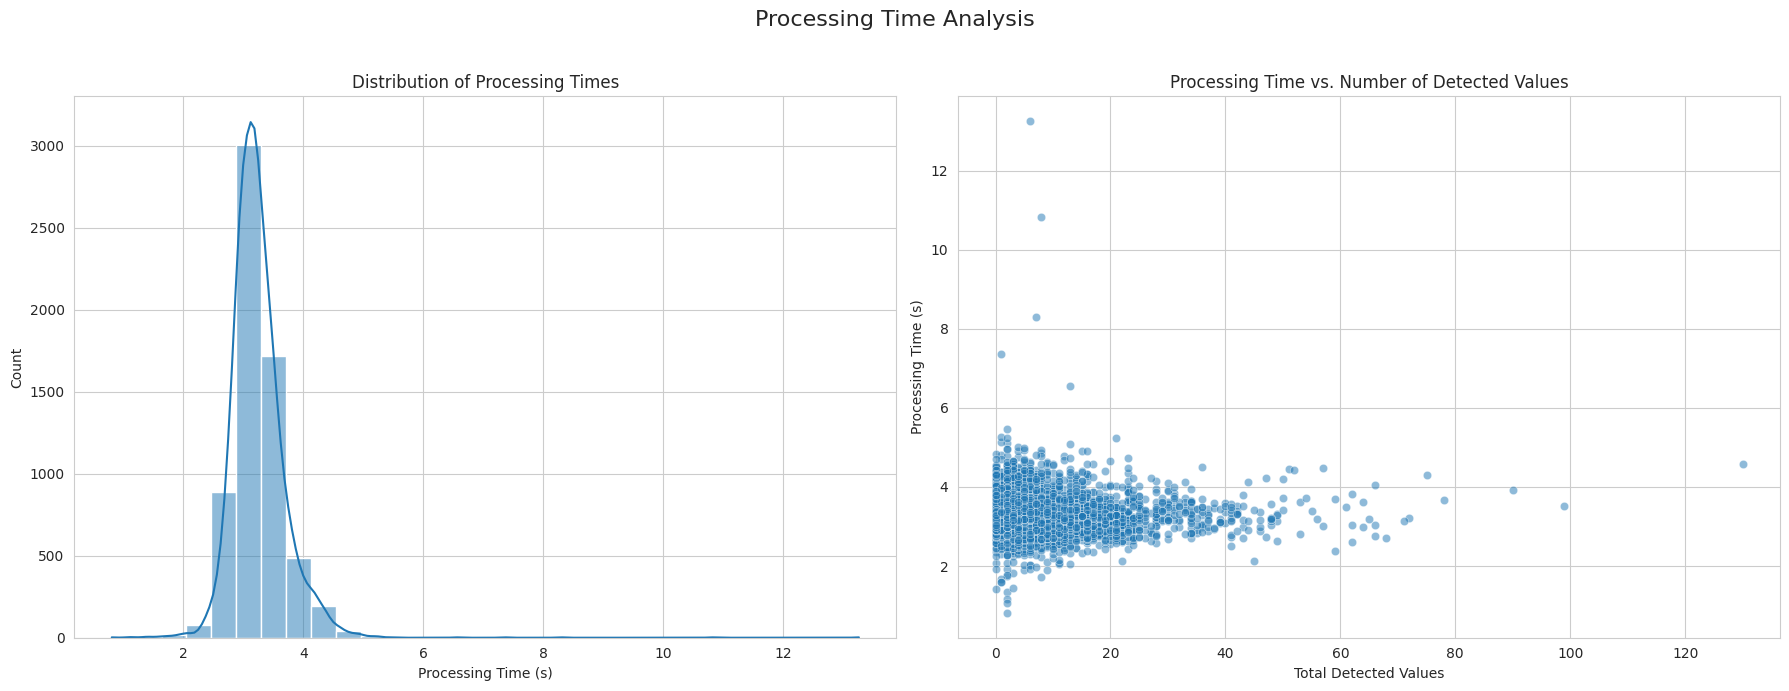

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Processing Time Analysis', fontsize=16)

# Histogram of Processing Times
sns.histplot(data=df, x='Processing Time (s)', ax=axes[0], bins=30, kde=True)
axes[0].set_title('Distribution of Processing Times')

# Scatter plot of Processing Time vs. Total Detected Values
sns.scatterplot(data=df, x='Total Detected Values', y='Processing Time (s)', ax=axes[1], alpha=0.5)
axes[1].set_title('Processing Time vs. Number of Detected Values')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()